In [1]:
import os
import numpy as np
import glob

In [2]:
# Directory containing the .md files
md_dir = "./../reports/prompt_vs_workflow"

# List to store the contents of all .md files
md_files_contents = {}

# Iterate through all files in the directory
for filename in os.listdir(md_dir):
    if filename.endswith(".md"):
        file_path = os.path.join(md_dir, filename)
        with open(file_path, "r") as f:
            model_name = filename.replace("multi_evaluator_report_", "").replace(".md", "")
            # Clarify the gemini-2.5-pro names
            if model_name in 'single-prompt-gemini-2.5-pro-exp-03-25': 
                model_name = 'single-prompt-gemini-2.5-pro'
            if model_name in 'gemini-2.5-pro-preview-05-06': 
                model_name = 'gemini-2.5-pro'
            md_files_contents[model_name] = f.read()

# Result
md_files_contents


{'llama4-scout': '# Factual evaluation of the llama4-scout summarizer by a LLM jury\n\n## Jury members: claude-3.5-sonnet-v2, llama4-maverick, deepseek-r1\n\n## Main results\n\n### A. Presence of important facts\n\n**Score: 54/100** (95% CI: 44-64) (higher values better)\n\n**Feedback regarding the important facts missing:**\n\nHospital course summaries frequently omit critical clinical facts due to recurring patterns: (1) **Procedural/device omissions**, where specific interventions (e.g., JP drains in Patient 0, adhesion takedown in Patient 2) are excluded despite documenting related surgeries; (2) **Unlinked diagnoses**, where coexisting findings (e.g., Patient 3’s chest pain and port thrombus) are described separately without causal attribution; (3) **Incomplete medication documentation**, including dose changes (Patient 6’s insulin switch from Lantus to Levemir) or therapy rationale (Patient 9’s finasteride for UTI prevention); (4) **Absence of explicit descriptors**, such as "com

In [3]:
import re

scores_names = ["presence_of_important_facts", "contradicting_important_facts"]

def extract_scores(md_content):
    """
    Extracts all scores from the markdown content.
    Returns a list of scores as int.
    -First score: Presence of important facts
    -Second score: Hospital course summaries contradicting important facts
    """
    matches = re.findall(r"\*\*Score:\s*(\d+)/100\*\*", md_content)
    return {scores_names[i]: int(match) for i, match in enumerate(matches)}

# Example usage
extract_scores(md_files_contents["deepseek-r1"])

{'presence_of_important_facts': 62, 'contradicting_important_facts': 16}

In [4]:
model_scores = {}
for k,v in md_files_contents.items():
    model_scores[k] = extract_scores(v)
    
# Result
model_scores

{'llama4-scout': {'presence_of_important_facts': 54,
  'contradicting_important_facts': 16},
 'single-prompt-deepseek-r1': {'presence_of_important_facts': 58,
  'contradicting_important_facts': 18},
 'single-prompt-gpt-4o': {'presence_of_important_facts': 48,
  'contradicting_important_facts': 12},
 'phi-3-5-mini-instruct': {'presence_of_important_facts': 38,
  'contradicting_important_facts': 25},
 'gpt-4o': {'presence_of_important_facts': 65,
  'contradicting_important_facts': 10},
 'gemini-2.5-pro': {'presence_of_important_facts': 68,
  'contradicting_important_facts': 18},
 'single-prompt-gemini-2.5-pro': {'presence_of_important_facts': 65,
  'contradicting_important_facts': 18},
 'single-prompt-phi-3-5-mini-instruct': {'presence_of_important_facts': 36,
  'contradicting_important_facts': 16},
 'claude-3-5-sonnet-v2': {'presence_of_important_facts': 60,
  'contradicting_important_facts': 16},
 'single-prompt-claude-3-5-sonnet-v2': {'presence_of_important_facts': 53,
  'contradictin

In [5]:
base_model_names = set(model_name.replace("single-prompt-", "") for model_name in model_scores.keys())
base_model_names

{'claude-3-5-sonnet-v2',
 'deepseek-r1',
 'gemini-2.5-pro',
 'gpt-4o',
 'llama4-scout',
 'phi-3-5-mini-instruct'}

In [6]:
base_model_scores = {base_model_name: None for base_model_name in base_model_names}

for base_model_name, v in base_model_scores.items():
    all_score_per_base_model = {"workflow-" + base_model_name: model_scores[base_model_name], "single-prompt-" + base_model_name: model_scores["single-prompt-" + base_model_name]}
    base_model_scores[base_model_name] = all_score_per_base_model

base_model_scores

{'claude-3-5-sonnet-v2': {'workflow-claude-3-5-sonnet-v2': {'presence_of_important_facts': 60,
   'contradicting_important_facts': 16},
  'single-prompt-claude-3-5-sonnet-v2': {'presence_of_important_facts': 53,
   'contradicting_important_facts': 15}},
 'phi-3-5-mini-instruct': {'workflow-phi-3-5-mini-instruct': {'presence_of_important_facts': 38,
   'contradicting_important_facts': 25},
  'single-prompt-phi-3-5-mini-instruct': {'presence_of_important_facts': 36,
   'contradicting_important_facts': 16}},
 'deepseek-r1': {'workflow-deepseek-r1': {'presence_of_important_facts': 62,
   'contradicting_important_facts': 16},
  'single-prompt-deepseek-r1': {'presence_of_important_facts': 58,
   'contradicting_important_facts': 18}},
 'gemini-2.5-pro': {'workflow-gemini-2.5-pro': {'presence_of_important_facts': 68,
   'contradicting_important_facts': 18},
  'single-prompt-gemini-2.5-pro': {'presence_of_important_facts': 65,
   'contradicting_important_facts': 18}},
 'gpt-4o': {'workflow-gpt-

In [7]:
def extract_patient_no(path):
    """
    Extract the patient number from the path
    """
    match = re.search(r'patient_(\d+)', path)
    return "patient_" + match.group(1)

def extract_time_seconds(text):
    """
    Extract the time in seconds from a string like 'Took 7.27 seconds to summarize...'
    Returns the time as a float
    """
    match = re.search(r'Took\s+(\d+\.?\d*)\s+seconds', text)
    return float(match.group(1))


In [8]:
summaries_dir = "./../../prototyping/generated_dc_sum/testset"

def extract_times_per_model(model_name):
    if model_name == "gemini-2.5-pro":
        return {f"patient_{i}":300 for i in range(30)} #TODO: rerun gemini to fix this
    if model_name == "single-prompt-gemini-2.5-pro":
        return {f"patient_{i}":30 for i in range(30)} #TODO: rerun gemini to fix this
        
    file_pat = f"**/{model_name}.md"
    pattern = os.path.join(summaries_dir, file_pat)
    md_files = glob.glob(pattern, recursive=True)

    # Read all markdown files and store their contents in a dict
    md_files_contents = {}
    for path in md_files:
        with open(path, "r") as f:
            md_files_contents[extract_patient_no(path)] = extract_time_seconds(f.read())

    return md_files_contents

# Example usage
extract_times_per_model("llama4-scout")

{'patient_24': 34.31,
 'patient_23': 629.61,
 'patient_15': 92.04,
 'patient_12': 110.29,
 'patient_13': 55.71,
 'patient_14': 219.23,
 'patient_22': 59.79,
 'patient_25': 114.93,
 'patient_8': 197.18,
 'patient_1': 99.91,
 'patient_6': 66.58,
 'patient_7': 198.31,
 'patient_0': 187.31,
 'patient_9': 65.02,
 'patient_20': 64.38,
 'patient_27': 110.74,
 'patient_18': 59.67,
 'patient_11': 130.04,
 'patient_16': 98.75,
 'patient_29': 381.06,
 'patient_17': 45.75,
 'patient_28': 148.12,
 'patient_10': 79.94,
 'patient_26': 112.61,
 'patient_19': 93.5,
 'patient_21': 124.76,
 'patient_5': 62.49,
 'patient_2': 110.99,
 'patient_3': 253.25,
 'patient_4': 125.53}

In [9]:
times_per_model = {model:extract_times_per_model(model) for model in model_scores.keys()}
times_per_model

{'llama4-scout': {'patient_24': 34.31,
  'patient_23': 629.61,
  'patient_15': 92.04,
  'patient_12': 110.29,
  'patient_13': 55.71,
  'patient_14': 219.23,
  'patient_22': 59.79,
  'patient_25': 114.93,
  'patient_8': 197.18,
  'patient_1': 99.91,
  'patient_6': 66.58,
  'patient_7': 198.31,
  'patient_0': 187.31,
  'patient_9': 65.02,
  'patient_20': 64.38,
  'patient_27': 110.74,
  'patient_18': 59.67,
  'patient_11': 130.04,
  'patient_16': 98.75,
  'patient_29': 381.06,
  'patient_17': 45.75,
  'patient_28': 148.12,
  'patient_10': 79.94,
  'patient_26': 112.61,
  'patient_19': 93.5,
  'patient_21': 124.76,
  'patient_5': 62.49,
  'patient_2': 110.99,
  'patient_3': 253.25,
  'patient_4': 125.53},
 'single-prompt-deepseek-r1': {'patient_24': 30.02,
  'patient_23': 123.07,
  'patient_15': 39.35,
  'patient_12': 27.24,
  'patient_13': 26.17,
  'patient_14': 41.91,
  'patient_22': 44.79,
  'patient_25': 44.47,
  'patient_8': 63.49,
  'patient_1': 32.73,
  'patient_6': 29.91,
  'patie

In [10]:
avg_time_per_model = {}
for k in model_scores.keys():
    if "single-prompt-" not in k:
        model_name = "workflow-" + k
    else:
        model_name = k
    avg_time_per_model[model_name] = np.mean(list(times_per_model[k].values()))

avg_time_per_model

{'workflow-llama4-scout': np.float64(137.72666666666663),
 'single-prompt-deepseek-r1': np.float64(39.14700000000001),
 'single-prompt-gpt-4o': np.float64(15.490333333333334),
 'workflow-phi-3-5-mini-instruct': np.float64(1226.2496666666666),
 'workflow-gpt-4o': np.float64(239.3923333333333),
 'workflow-gemini-2.5-pro': np.float64(300.0),
 'single-prompt-gemini-2.5-pro': np.float64(30.0),
 'single-prompt-phi-3-5-mini-instruct': np.float64(63.605666666666664),
 'workflow-claude-3-5-sonnet-v2': np.float64(274.90999999999997),
 'single-prompt-claude-3-5-sonnet-v2': np.float64(23.404000000000003),
 'single-prompt-llama4-scout': np.float64(11.245000000000001),
 'workflow-deepseek-r1': np.float64(1943.0026666666665)}

In [11]:
model_price_per_hour = {
    "gpt-4o": 1.260,                # $2.00 in  / $8.00  out per M tok
    "claude-3-5-sonnet-v2": 2.160,  # $3.00 in  / $15.00 out per M tok 
    "llama4-scout": 0.1017,         # $0.18 in / $0.59 out per M tok
    "phi-3-5-mini-instruct": 0.1008,# $0.16 in / $0.64 out per M tok
    "deepseek-r1": 0.3456,          # $0.55 in / $2.19 out per M tok
    "gemini-2.5-pro": 1.2375        # $1.25 in / $10.00 out per M tok
}

# Calculate average cost per model using time and pricing data
avg_cost_per_model = {}

for model_name, avg_time in avg_time_per_model.items():
    # Extract base model name (remove workflow- or single-prompt- prefix)
    if model_name.startswith("workflow-"):
        base_model = model_name.replace("workflow-", "")
    elif model_name.startswith("single-prompt-"):
        base_model = model_name.replace("single-prompt-", "")
    
    # Get price per hour for the base model
    price_per_hour = model_price_per_hour[base_model]
    # Convert seconds to hours and calculate cost
    avg_cost = (avg_time / 3600) * price_per_hour
    avg_cost_per_model[model_name] = avg_cost

avg_cost_per_model


{'workflow-llama4-scout': np.float64(0.0038907783333333324),
 'single-prompt-deepseek-r1': np.float64(0.003758112000000002),
 'single-prompt-gpt-4o': np.float64(0.005421616666666668),
 'workflow-phi-3-5-mini-instruct': np.float64(0.03433499066666666),
 'workflow-gpt-4o': np.float64(0.08378731666666665),
 'workflow-gemini-2.5-pro': np.float64(0.103125),
 'single-prompt-gemini-2.5-pro': np.float64(0.0103125),
 'single-prompt-phi-3-5-mini-instruct': np.float64(0.0017809586666666668),
 'workflow-claude-3-5-sonnet-v2': np.float64(0.164946),
 'single-prompt-claude-3-5-sonnet-v2': np.float64(0.014042400000000003),
 'single-prompt-llama4-scout': np.float64(0.00031767125000000003),
 'workflow-deepseek-r1': np.float64(0.186528256)}

In [12]:
base_model_scores

{'claude-3-5-sonnet-v2': {'workflow-claude-3-5-sonnet-v2': {'presence_of_important_facts': 60,
   'contradicting_important_facts': 16},
  'single-prompt-claude-3-5-sonnet-v2': {'presence_of_important_facts': 53,
   'contradicting_important_facts': 15}},
 'phi-3-5-mini-instruct': {'workflow-phi-3-5-mini-instruct': {'presence_of_important_facts': 38,
   'contradicting_important_facts': 25},
  'single-prompt-phi-3-5-mini-instruct': {'presence_of_important_facts': 36,
   'contradicting_important_facts': 16}},
 'deepseek-r1': {'workflow-deepseek-r1': {'presence_of_important_facts': 62,
   'contradicting_important_facts': 16},
  'single-prompt-deepseek-r1': {'presence_of_important_facts': 58,
   'contradicting_important_facts': 18}},
 'gemini-2.5-pro': {'workflow-gemini-2.5-pro': {'presence_of_important_facts': 68,
   'contradicting_important_facts': 18},
  'single-prompt-gemini-2.5-pro': {'presence_of_important_facts': 65,
   'contradicting_important_facts': 18}},
 'gpt-4o': {'workflow-gpt-

In [13]:
def extract_model_scores_for_a_task(task):
    """
    Extract the scores for a given task from the model score
    The task is "presence_of_important_facts" or "contradicting_important_facts"
    """
    model_scores_for_a_task = {}

    model_types = ["workflow-", "single-prompt-"]

    for model_type in model_types:
        for k,v in base_model_scores.items():
            model_scores_for_a_task[model_type+k] = v[model_type+k][task]
        
    return model_scores_for_a_task

# Example usage
extract_model_scores_for_a_task("presence_of_important_facts")

{'workflow-claude-3-5-sonnet-v2': 60,
 'workflow-phi-3-5-mini-instruct': 38,
 'workflow-deepseek-r1': 62,
 'workflow-gemini-2.5-pro': 68,
 'workflow-gpt-4o': 65,
 'workflow-llama4-scout': 54,
 'single-prompt-claude-3-5-sonnet-v2': 53,
 'single-prompt-phi-3-5-mini-instruct': 36,
 'single-prompt-deepseek-r1': 58,
 'single-prompt-gemini-2.5-pro': 65,
 'single-prompt-gpt-4o': 48,
 'single-prompt-llama4-scout': 50}

In [14]:
def get_y_label(task):
    if task == "presence_of_important_facts":
        return "MedFactEval Score for Fact Presence (/100)"
    elif task == "contradicting_important_facts":
        return "MedFactEval Score for Contradicting Important Facts (/100)"

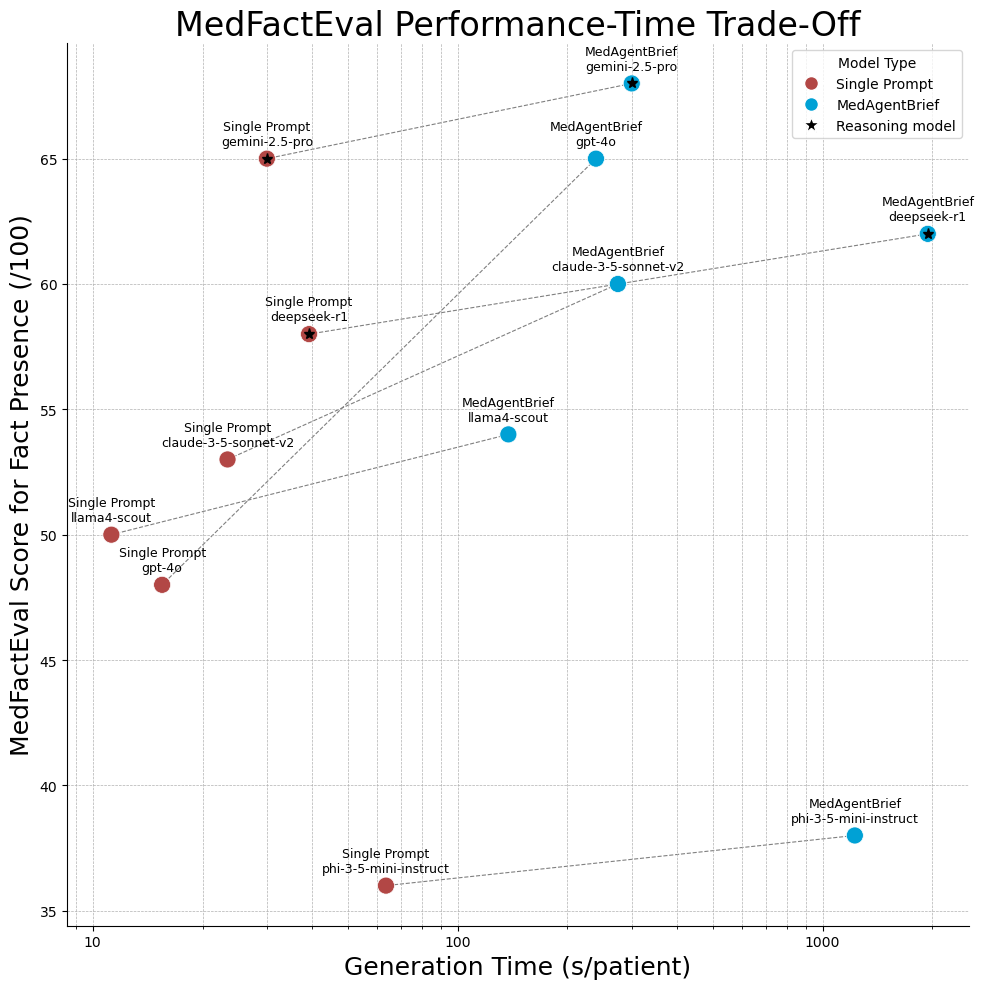

In [15]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

avg_per_model = avg_time_per_model
task = "presence_of_important_facts"
y_label = get_y_label(task)

# Prepare data for plotting
labels = list(avg_per_model.keys())
x_values = list(avg_per_model.values())
y_values = [extract_model_scores_for_a_task(task)[label] for label in labels]

jama_red = '#b24745'
jama_blue = '#00a1d5'
colors = [jama_red if 'single-prompt' in label else jama_blue for label in labels]
sizes = [150 for label in labels]

labels = [label.replace("workflow-", "MedAgentBrief\n").replace("single-prompt-", "Single Prompt\n") for label in labels]


# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Create the scatter plot
scatter = ax.scatter(x_values, y_values, c=colors, s=sizes, edgecolors='w', linewidth=0.5, zorder=2)

# Add lines connecting workflow and single-prompt versions of the same model
for base_model in base_model_names:
    workflow_model = "workflow-" + base_model
    sp_model = "single-prompt-" + base_model
    
    # Check if both models exist in the data
    if workflow_model in avg_per_model and sp_model in avg_per_model:
        scores = extract_model_scores_for_a_task(task)
        
        # Check if scores are available for both
        if workflow_model in scores and sp_model in scores:
            x_coords = [avg_per_model[workflow_model], avg_per_model[sp_model]]
            y_coords = [scores[workflow_model], scores[sp_model]]
            
            ax.plot(x_coords, y_coords, color='gray', linestyle='--', linewidth=0.8, zorder=1)

# Set x-axis to log scale
ax.set_xscale('log')
ax.set_xlim(left=8.5)

# Customize x-axis labels to show 10, 100, 1000 instead of powers of 10
ax.set_xticks([10, 100, 1000])
ax.set_xticklabels(['10', '100', '1000'])

# Add titles and labels
ax.set_title('MedFactEval Performance-Time Trade-Off', fontsize=24)
ax.set_xlabel('Generation Time (s/patient)', fontsize=18)
ax.set_ylabel(y_label, fontsize=18)

for i, label in enumerate(labels):
    # Add the text label for the model
    ax.annotate(label, (x_values[i], y_values[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    if 'gemini' in label.lower() or 'deepseek-r1' in label.lower():
        ax.plot(x_values[i], y_values[i], 
                marker='*', 
                color='black', 
                markersize=8, 
                linestyle='None',
                zorder=3)


legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Single Prompt', markerfacecolor=jama_red, markersize=10),
    Line2D([0], [0], marker='o', color='w', label='MedAgentBrief', markerfacecolor=jama_blue, markersize=10),
    Line2D([0], [0], marker='*', color='w', label='Reasoning model', markerfacecolor='black', markersize=12, linestyle='None')
]

ax.legend(handles=legend_elements, title="Model Type", loc='upper right')
        
# Show plot
ax.grid(True, which="both", ls="--", linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# save the plot as a pdf
plt.savefig('./../pdfs/tradeoffs/time_fact_presence.pdf', dpi=300, bbox_inches='tight')
plt.show()


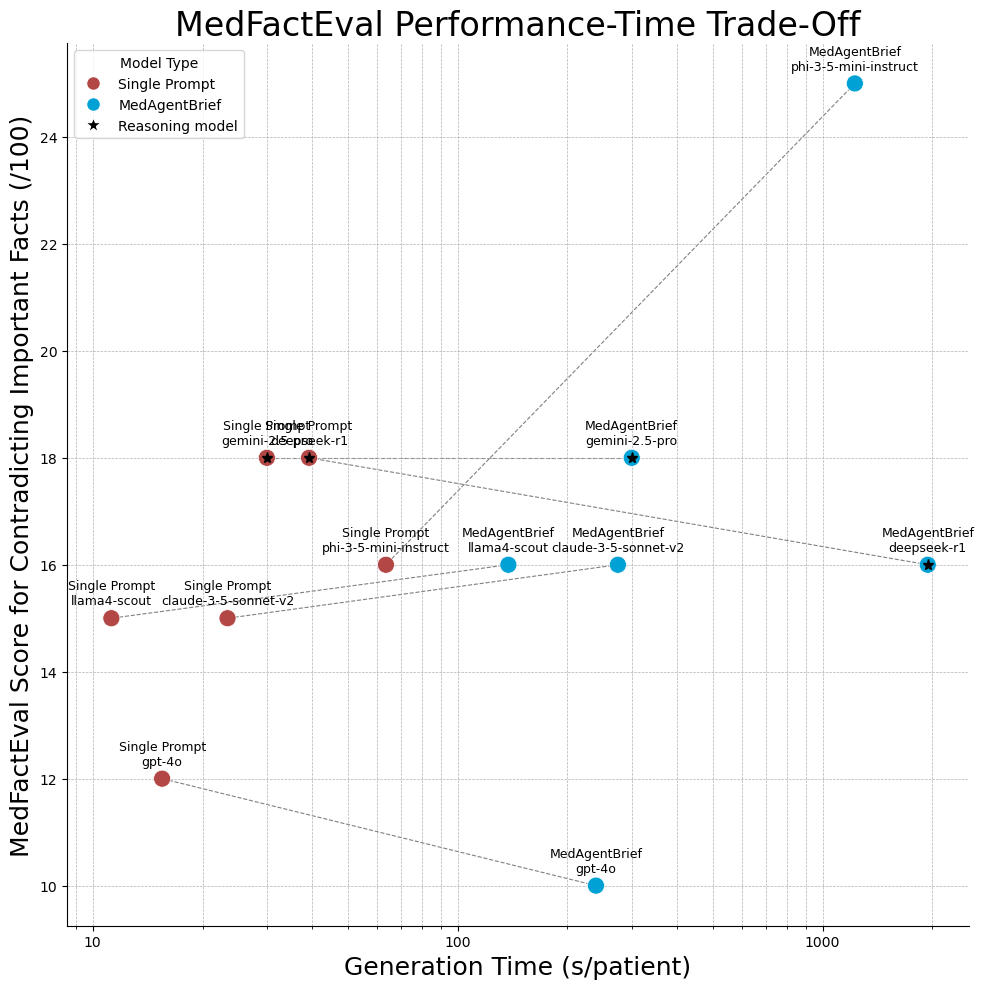

In [16]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

avg_per_model = avg_time_per_model
task = "contradicting_important_facts"
y_label = get_y_label(task)

# Prepare data for plotting
labels = list(avg_per_model.keys())
x_values = list(avg_per_model.values())
y_values = [extract_model_scores_for_a_task(task)[label] for label in labels]

jama_red = '#b24745'
jama_blue = '#00a1d5'
colors = [jama_red if 'single-prompt' in label else jama_blue for label in labels]
sizes = [150 for label in labels]

labels = [label.replace("workflow-", "MedAgentBrief\n").replace("single-prompt-", "Single Prompt\n") for label in labels]


# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Create the scatter plot
scatter = ax.scatter(x_values, y_values, c=colors, s=sizes, edgecolors='w', linewidth=0.5, zorder=2)

# Add lines connecting workflow and single-prompt versions of the same model
for base_model in base_model_names:
    workflow_model = "workflow-" + base_model
    sp_model = "single-prompt-" + base_model
    
    # Check if both models exist in the data
    if workflow_model in avg_per_model and sp_model in avg_per_model:
        scores = extract_model_scores_for_a_task(task)
        
        # Check if scores are available for both
        if workflow_model in scores and sp_model in scores:
            x_coords = [avg_per_model[workflow_model], avg_per_model[sp_model]]
            y_coords = [scores[workflow_model], scores[sp_model]]
            
            ax.plot(x_coords, y_coords, color='gray', linestyle='--', linewidth=0.8, zorder=1)

# Set x-axis to log scale
ax.set_xscale('log')
ax.set_xlim(left=8.5)

# Customize x-axis labels to show 10, 100, 1000 instead of powers of 10
ax.set_xticks([10, 100, 1000])
ax.set_xticklabels(['10', '100', '1000'])

# Add titles and labels
ax.set_title('MedFactEval Performance-Time Trade-Off', fontsize=24)
ax.set_xlabel('Generation Time (s/patient)', fontsize=18)
ax.set_ylabel(y_label, fontsize=18)

for i, label in enumerate(labels):
    # Add the text label for the model
    ax.annotate(label, (x_values[i], y_values[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    if 'gemini' in label.lower() or 'deepseek-r1' in label.lower():
        ax.plot(x_values[i], y_values[i], 
                marker='*', 
                color='black', 
                markersize=8, 
                linestyle='None',
                zorder=3)


legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Single Prompt', markerfacecolor=jama_red, markersize=10),
    Line2D([0], [0], marker='o', color='w', label='MedAgentBrief', markerfacecolor=jama_blue, markersize=10),
    Line2D([0], [0], marker='*', color='w', label='Reasoning model', markerfacecolor='black', markersize=12, linestyle='None')
]

ax.legend(handles=legend_elements, title="Model Type", loc='upper left')
        
# Show plot
ax.grid(True, which="both", ls="--", linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# save the plot as a pdf
plt.savefig('./../pdfs/tradeoffs/time_fact_contradiction.pdf', dpi=300, bbox_inches='tight')
plt.show()

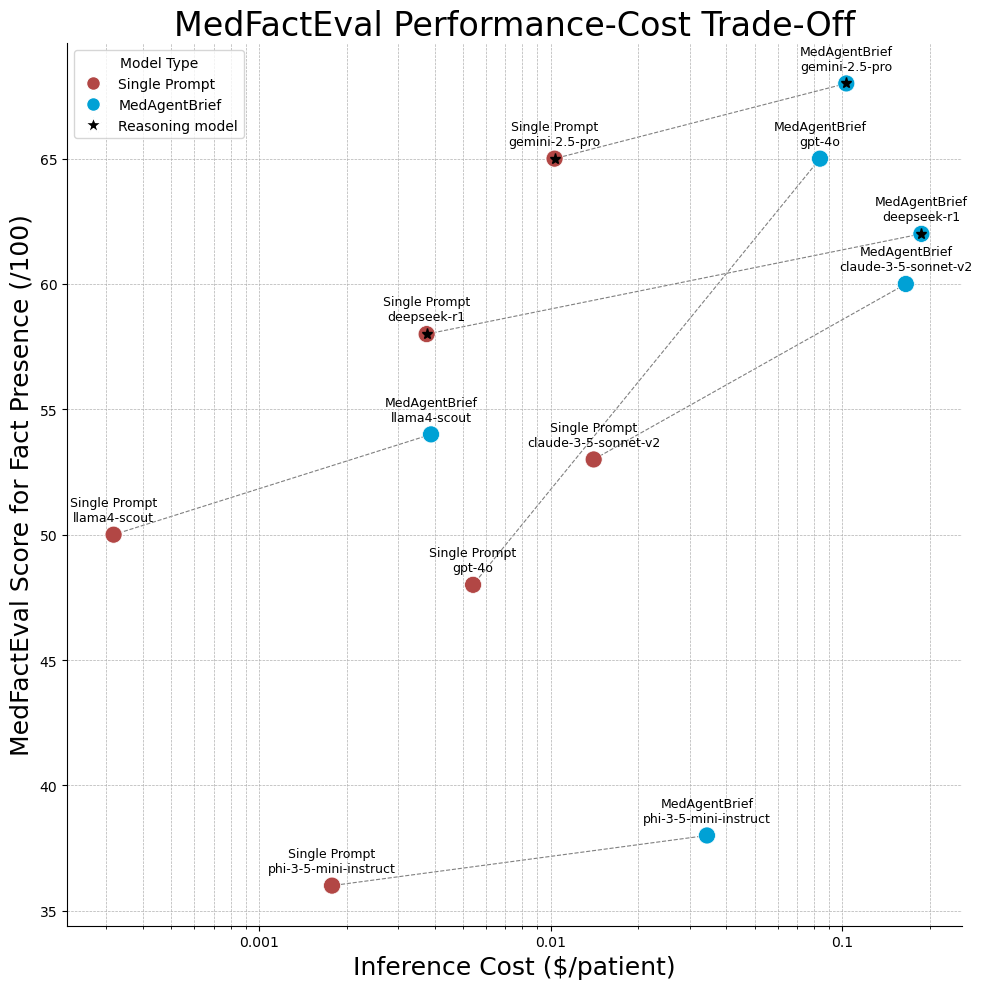

In [17]:
avg_per_model = avg_cost_per_model
task = "presence_of_important_facts"
y_label = get_y_label(task)

# Prepare data for plotting
labels = list(avg_per_model.keys())
x_values = list(avg_per_model.values())
y_values = [extract_model_scores_for_a_task(task)[label] for label in labels]

jama_red = '#b24745'
jama_blue = '#00a1d5'
colors = [jama_red if 'single-prompt' in label else jama_blue for label in labels]
sizes = [150 for label in labels]

labels = [label.replace("workflow-", "MedAgentBrief\n").replace("single-prompt-", "Single Prompt\n") for label in labels]


# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Create the scatter plot
scatter = ax.scatter(x_values, y_values, c=colors, s=sizes, edgecolors='w', linewidth=0.5, zorder=2)

# Add lines connecting workflow and single-prompt versions of the same model
for base_model in base_model_names:
    workflow_model = "workflow-" + base_model
    sp_model = "single-prompt-" + base_model
    
    # Check if both models exist in the data
    if workflow_model in avg_per_model and sp_model in avg_per_model:
        scores = extract_model_scores_for_a_task(task)
        
        # Check if scores are available for both
        if workflow_model in scores and sp_model in scores:
            x_coords = [avg_per_model[workflow_model], avg_per_model[sp_model]]
            y_coords = [scores[workflow_model], scores[sp_model]]
            
            ax.plot(x_coords, y_coords, color='gray', linestyle='--', linewidth=0.8, zorder=1)

# Set x-axis to log scale
ax.set_xscale('log')
ax.set_xlim(left=0.00022)

# Customize x-axis labels to show 10, 100, 1000 instead of powers of 10
ax.set_xticks([0.001, 0.01, 0.1])
ax.set_xticklabels(['0.001', '0.01', '0.1'])

# Add titles and labels
ax.set_title('MedFactEval Performance-Cost Trade-Off', fontsize=24)
ax.set_xlabel('Inference Cost ($/patient)', fontsize=18)
ax.set_ylabel(y_label, fontsize=18)

for i, label in enumerate(labels):
    # Add the text label for the model
    ax.annotate(label, (x_values[i], y_values[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    if 'gemini' in label.lower() or 'deepseek-r1' in label.lower():
        ax.plot(x_values[i], y_values[i], 
                marker='*', 
                color='black', 
                markersize=8, 
                linestyle='None',
                zorder=3)


legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Single Prompt', markerfacecolor=jama_red, markersize=10),
    Line2D([0], [0], marker='o', color='w', label='MedAgentBrief', markerfacecolor=jama_blue, markersize=10),
    Line2D([0], [0], marker='*', color='w', label='Reasoning model', markerfacecolor='black', markersize=12, linestyle='None')
]

ax.legend(handles=legend_elements, title="Model Type", loc='upper left')
        
# Show plot
ax.grid(True, which="both", ls="--", linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# save the plot as a pdf
plt.savefig('./../pdfs/tradeoffs/cost_fact_presence.pdf', dpi=300, bbox_inches='tight')
plt.show()

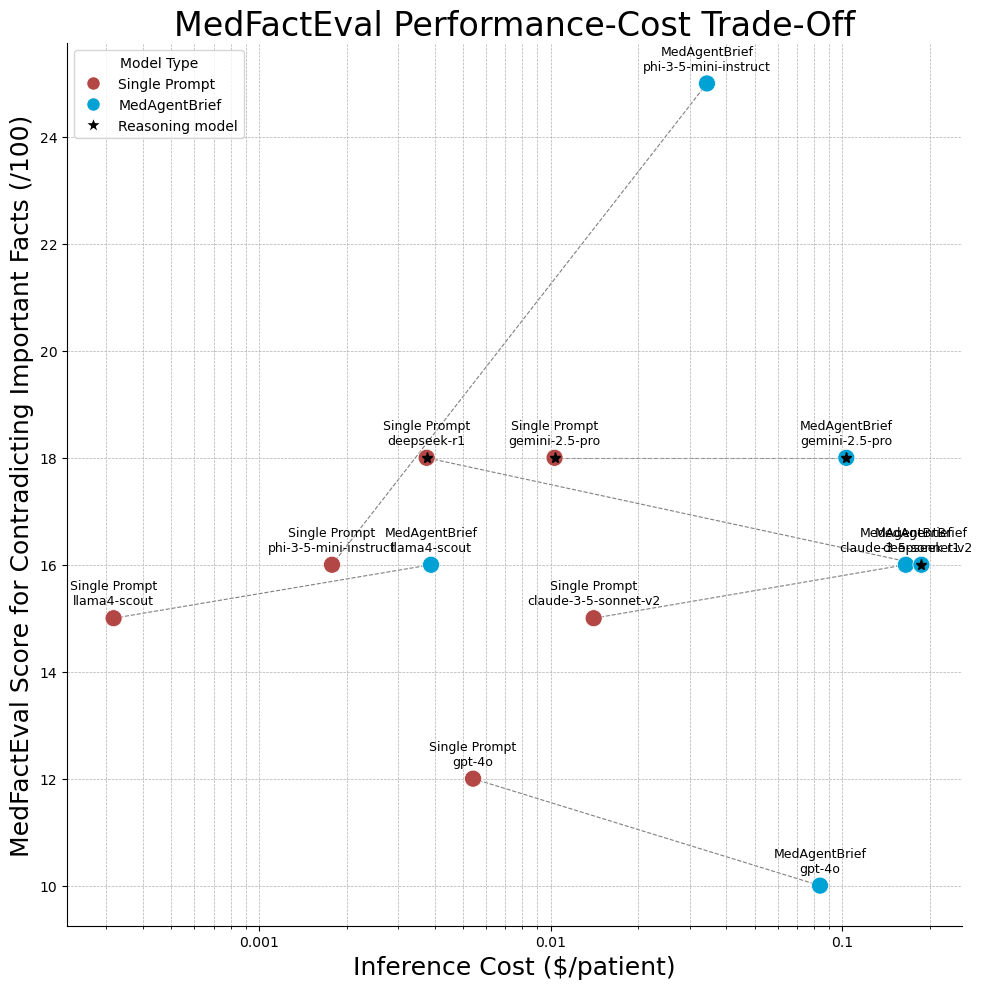

In [18]:
avg_per_model = avg_cost_per_model
task = "contradicting_important_facts"
y_label = get_y_label(task)

# Prepare data for plotting
labels = list(avg_per_model.keys())
x_values = list(avg_per_model.values())
y_values = [extract_model_scores_for_a_task(task)[label] for label in labels]

jama_red = '#b24745'
jama_blue = '#00a1d5'
colors = [jama_red if 'single-prompt' in label else jama_blue for label in labels]
sizes = [150 for label in labels]

labels = [label.replace("workflow-", "MedAgentBrief\n").replace("single-prompt-", "Single Prompt\n") for label in labels]


# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Create the scatter plot
scatter = ax.scatter(x_values, y_values, c=colors, s=sizes, edgecolors='w', linewidth=0.5, zorder=2)

# Add lines connecting workflow and single-prompt versions of the same model
for base_model in base_model_names:
    workflow_model = "workflow-" + base_model
    sp_model = "single-prompt-" + base_model
    
    # Check if both models exist in the data
    if workflow_model in avg_per_model and sp_model in avg_per_model:
        scores = extract_model_scores_for_a_task(task)
        
        # Check if scores are available for both
        if workflow_model in scores and sp_model in scores:
            x_coords = [avg_per_model[workflow_model], avg_per_model[sp_model]]
            y_coords = [scores[workflow_model], scores[sp_model]]
            
            ax.plot(x_coords, y_coords, color='gray', linestyle='--', linewidth=0.8, zorder=1)

# Set x-axis to log scale
ax.set_xscale('log')
ax.set_xlim(left=0.00022)

# Customize x-axis labels to show 10, 100, 1000 instead of powers of 10
ax.set_xticks([0.001, 0.01, 0.1])
ax.set_xticklabels(['0.001', '0.01', '0.1'])

# Add titles and labels
ax.set_title('MedFactEval Performance-Cost Trade-Off', fontsize=24)
ax.set_xlabel('Inference Cost ($/patient)', fontsize=18)
ax.set_ylabel(y_label, fontsize=18)

for i, label in enumerate(labels):
    # Add the text label for the model
    ax.annotate(label, (x_values[i], y_values[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    if 'gemini' in label.lower() or 'deepseek-r1' in label.lower():
        ax.plot(x_values[i], y_values[i], 
                marker='*', 
                color='black', 
                markersize=8, 
                linestyle='None',
                zorder=3)


legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Single Prompt', markerfacecolor=jama_red, markersize=10),
    Line2D([0], [0], marker='o', color='w', label='MedAgentBrief', markerfacecolor=jama_blue, markersize=10),
    Line2D([0], [0], marker='*', color='w', label='Reasoning model', markerfacecolor='black', markersize=12, linestyle='None')
]

ax.legend(handles=legend_elements, title="Model Type", loc='upper left')
        
# Show plot
ax.grid(True, which="both", ls="--", linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# save the plot as a pdf
plt.savefig('./../pdfs/tradeoffs/cost_fact_contradiction.pdf', dpi=300, bbox_inches='tight')
plt.show()